In [1]:
# load libraries
import pandas as pd
import numpy as np
import re
import nltk
#nltk.download()
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

The dataset can be downloaded as a zip file from: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

In [2]:
messages = pd.read_csv('spam_classifier_data/SMSSpamCollection', sep='\t',
                      names=['label', 'text'])

## Data Cleaning and Preprocessing
In this step, data cleaning and preprocessing will be performed in various phases. The first phase involves using standard natural language processing techniques such as removal of stopwords, conversion to lowercase, word tokenization, stemming and lemmatization. In the second phase, class imbalance will be checked for, and any necessary corrections will be applied. 

### Text Cleaning

In [3]:
## data cleaning and preprocessing
stemmer = PorterStemmer()
corpus = []
for i in range(len(messages)):
    # remove characters or numbers apart from alphabets
    clean = re.sub('[^a-zA-Z]', ' ', messages['text'][i])
    # put everything in lowercase
    clean = clean.lower()
    # split the sentences to a list of words to apply stemming/lemmatization
    clean = clean.split()

    # perform stemming operation
    clean = [stemmer.stem(word) for word in clean if not word in stopwords.words('english')]
    # join the words again to form a string
    clean = ' '.join(clean)
    # append to list
    corpus.append(clean)

### Bag of Words Model
In this step, a simple bag of words model will be created, which will subsequently be used to train our Machine Learning algorithm. A bag-of-words model is used in natural langauge processing to represent a text as a bag of its words, where frequent words get a higher score. 

In [4]:
## create a bag of words model
# restrict maximum words to the most frequent ones using max_features attribute
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()
# create one-hot encoded label values (column:0 = ham, column:1 = spam)
y=pd.get_dummies(messages['label'])
# store back as categories for later use
y_cat = y.stack()
y_cat = pd.Series(pd.Categorical(y_cat[y_cat!=0].index.get_level_values(1)))
# drop the ham column. y=1 for spam, 0 for ham
y=y.iloc[:,1].values

### Imbalanced Data
Imbalanced datasets are characterized by an unequal distribution of classes. This can lead to predictions biased towards the class with greater instances. The accuracy metric could also be inaccurate in these cases. Here, any imbalance in class distribution will be checked, and corrected for using the *imblearn* library.

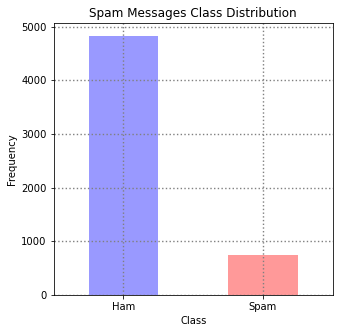

In [5]:
# plot the data imbalance
count_classes = pd.value_counts(messages['label'], sort = True)
plt.figure(figsize=(5,5))
count_classes.plot(kind = 'bar', rot=0, color=['blue', 'red'], alpha=0.4)
LABELS = ["Ham", "Spam"]
plt.title("Spam Messages Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = "dotted")
plt.show()

In [6]:
#get shapes of each class
ham = messages[messages['label']=='ham']
spam = messages[messages['label']=='spam']
print("Ham Class Shape: ", ham.shape, "\nSpam Class Shape", spam.shape)

Ham Class Shape:  (4825, 2) 
Spam Class Shape (747, 2)


In [7]:
#solve for imbalance using the SMOTTomek method
from imblearn.combine import SMOTETomek
smk = SMOTETomek(sampling_strategy=1)
X_over, y_over = smk.fit_resample(X, y)
#find shapes of classes post oversampling
ham_over = np.where(y_over==0)
spam_over = np.where(y_over==1)
print("Post Oversampling datashapes\nHam Class Shape: ", ham_over[0].shape, "\nSpam Class Shape: ", spam_over[0].shape)

Post Oversampling datashapes
Ham Class Shape:  (4822,) 
Spam Class Shape:  (4822,)


## Model Creation
In the next step, the data will be split into training and test data. Afterwards, a Naive Bayes Classifier is fit using the training data. The predict function is used afterwards to find class labels using the test data.

### Train Test Split
Perform a train test split with a test size of 20 %.

In [8]:
## train test split
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=0)

### Model Creation and Prediction
A Naive Bayes classifier is being used to fit on the training data. 

In [9]:
## model training using Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
# predict on test data
y_pred = nb_model.predict(X_test)

## Model Evaluation
The model performance is finally evaluated using different metrics. These include accuracy and confusion matrix.

In [10]:
# accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Naive Bayes Classifier using Bag of Words model: ", accuracy)

Accuracy of Naive Bayes Classifier using Bag of Words model:  0.8963193364437533


In [11]:
# confusion matrix
conmat=confusion_matrix(y_test, y_pred)
val=np.mat(conmat)
spam_classes=list(np.unique(y_cat))
df_cm = pd.DataFrame(val, index=spam_classes, columns=spam_classes)
print("Confusion Matrix: \n", df_cm)

Confusion Matrix: 
       ham  spam
ham   910    19
spam  181   819


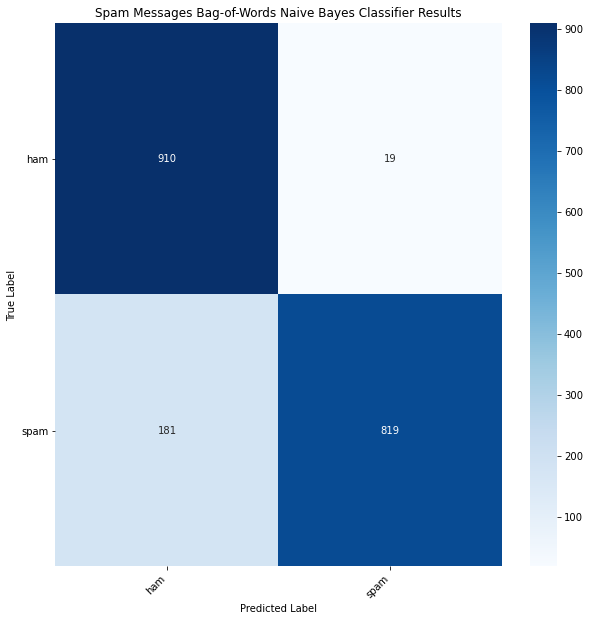

In [12]:
# plot confusion matrix as a heatmap
plt.figure(figsize=(10,10))
heat_map_predictions=sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
heat_map_predictions.yaxis.set_ticklabels(heat_map_predictions.yaxis.get_ticklabels(), rotation=0, ha='right')
heat_map_predictions.xaxis.set_ticklabels(heat_map_predictions.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Spam Messages Bag-of-Words Naive Bayes Classifier Results')
plt.show()

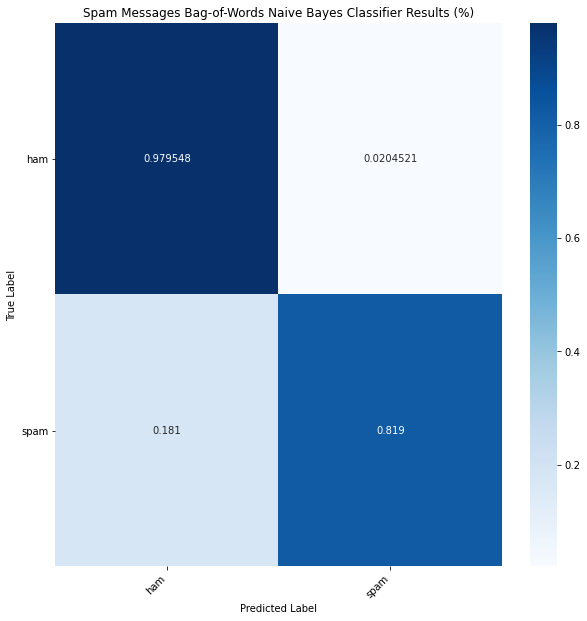

In [13]:
# display the results as percentages of the total number
df_cm = df_cm.astype('float')/df_cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,10))
heat_map_predictions=sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
heat_map_predictions.yaxis.set_ticklabels(heat_map_predictions.yaxis.get_ticklabels(), rotation=0, ha='right')
heat_map_predictions.xaxis.set_ticklabels(heat_map_predictions.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Spam Messages Bag-of-Words Naive Bayes Classifier Results (%)')
plt.show()

## TF-IDF Model
To improve accuracy, the TF-IDF model will now be employed. The TF-IDF weighs words in text based on their importance and frequency of occurance. The rest of the code will be kept same for comparison purposes. 

In [14]:
## create a TF-IDF model
# restrict maximum words to the most frequent ones using max_features attribute
tfidf = TfidfVectorizer(max_features=2500)
X_tfidf = tfidf.fit_transform(corpus).toarray()
# create one-hot encoded label values (column:0 = ham, column:1 = spam)
y=pd.get_dummies(messages['label'])
# store back as categories for later use
y_cat = y.stack()
y_cat = pd.Series(pd.Categorical(y_cat[y_cat!=0].index.get_level_values(1)))
# drop the ham column. y=1 for spam, 0 for ham
y=y.iloc[:,1].values

In [15]:
#solve for imbalance using the SMOTTomek method
from imblearn.combine import SMOTETomek
smk = SMOTETomek(sampling_strategy=1)
X_over_tfidf, y_over = smk.fit_resample(X_tfidf, y)
#find shapes of classes post oversampling
ham_over = np.where(y_over==0)
spam_over = np.where(y_over==1)
print("Post Oversampling datashapes\nHam Class Shape: ", ham_over[0].shape, "\nSpam Class Shape: ", spam_over[0].shape)

Post Oversampling datashapes
Ham Class Shape:  (4825,) 
Spam Class Shape:  (4825,)


In [16]:
## train test split
X_train, X_test, y_train, y_test = train_test_split(X_over_tfidf, y_over, test_size=0.2, random_state=0)

In [17]:
## model training using Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
# predict on test data
y_pred = nb_model.predict(X_test)

In [18]:
# accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Naive Bayes Classifier using Bag of Words model: ", accuracy)

Accuracy of Naive Bayes Classifier using Bag of Words model:  0.9844559585492227


In [19]:
# confusion matrix
conmat=confusion_matrix(y_test, y_pred)
val=np.mat(conmat)
spam_classes=list(np.unique(y_cat))
df_cm = pd.DataFrame(val, index=spam_classes, columns=spam_classes)
print("Confusion Matrix: \n", df_cm)

Confusion Matrix: 
       ham  spam
ham   923    19
spam   11   977


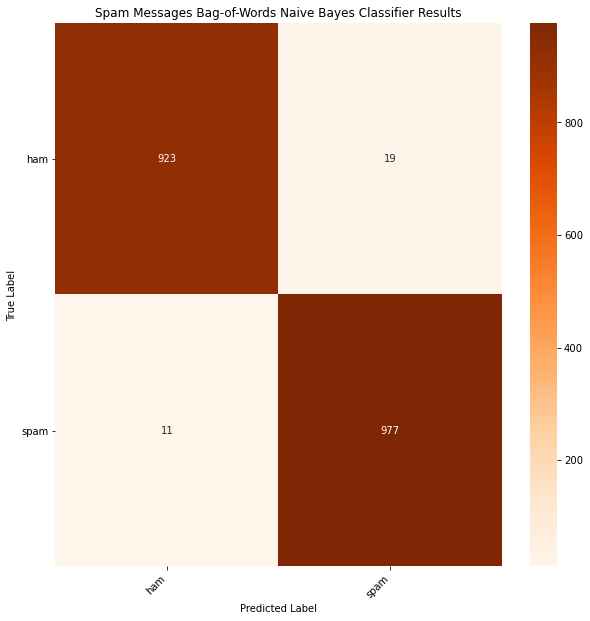

In [20]:
# plot confusion matrix as a heatmap
plt.figure(figsize=(10,10))
heat_map_predictions=sns.heatmap(df_cm, annot=True, cmap='Oranges', fmt='g')
heat_map_predictions.yaxis.set_ticklabels(heat_map_predictions.yaxis.get_ticklabels(), rotation=0, ha='right')
heat_map_predictions.xaxis.set_ticklabels(heat_map_predictions.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Spam Messages Bag-of-Words Naive Bayes Classifier Results')
plt.show()

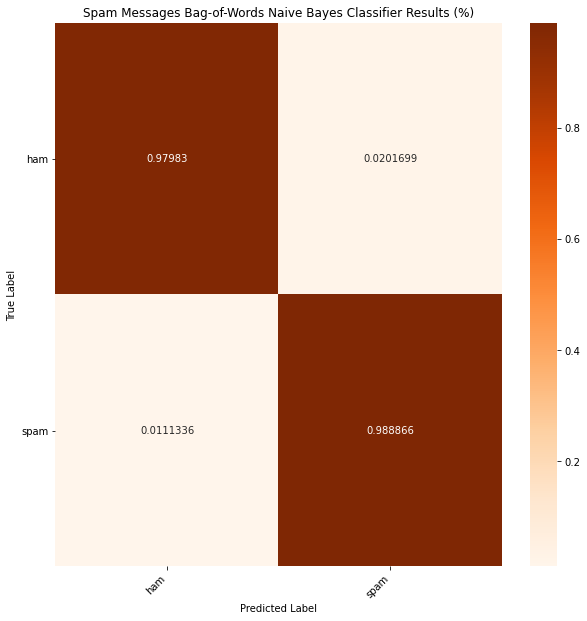

In [21]:
# display the results as percentages of the total number
df_cm = df_cm.astype('float')/df_cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,10))
heat_map_predictions=sns.heatmap(df_cm, annot=True, cmap='Oranges', fmt='g')
heat_map_predictions.yaxis.set_ticklabels(heat_map_predictions.yaxis.get_ticklabels(), rotation=0, ha='right')
heat_map_predictions.xaxis.set_ticklabels(heat_map_predictions.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Spam Messages Bag-of-Words Naive Bayes Classifier Results (%)')
plt.show()

## Word2Vec 
In a sentence, the order of words is usually important. The Bag-of-Words and TF-IDF model provide no semantic information present in the input text. These models can also be prone to overfitting. This could be seen with the TF-IDF model, which gave an accuracy of 98 %. The word2vec model solves for these issues by creating a vector of 32 or more dimensions for each word. This allows the model to preserve semantic information. The Naive Bayes classifier will be provided with vectors from a word2vec model in this section. The rest of the code will remain unchanged, for comparison purposes. 

In [36]:
## data cleaning and preprocessing
# word2vec model needs a list of lists
stemmer = PorterStemmer()
corpus = []
for i in range(len(messages)):
    # remove characters or numbers apart from alphabets
    clean = re.sub('[^a-zA-Z]', ' ', messages['text'][i])
    # put everything in lowercase
    clean = clean.lower()
    # split the sentences to a list of words to apply stemming/lemmatization
    clean = clean.split()
    # perform stemming operation
    clean = [stemmer.stem(word) for word in clean if not word in stopwords.words('english')]
    # append to list
    corpus.append(clean)

In [43]:
## create a Word2Vec model
w2vec = Word2Vec(corpus, min_count=1)
words = w2vec.wv.key_to_index
print(words)

{'u': 0, 'call': 1, 'go': 2, 'get': 3, 'ur': 4, 'gt': 5, 'lt': 6, 'come': 7, 'day': 8, 'ok': 9, 'free': 10, 'know': 11, 'love': 12, 'like': 13, 'time': 14, 'good': 15, 'want': 16, 'got': 17, 'text': 18, 'send': 19, 'txt': 20, 'need': 21, 'p': 22, 'one': 23, 'today': 24, 'n': 25, 'take': 26, 'stop': 27, 'see': 28, 'r': 29, 'home': 30, 'think': 31, 'repli': 32, 'lor': 33, 'k': 34, 'sorri': 35, 'still': 36, 'tell': 37, 'mobil': 38, 'back': 39, 'da': 40, 'dont': 41, 'make': 42, 'phone': 43, 'week': 44, 'pleas': 45, 'say': 46, 'hi': 47, 'new': 48, 'work': 49, 'pl': 50, 'later': 51, 'miss': 52, 'hope': 53, 'ask': 54, 'co': 55, 'msg': 56, 'min': 57, 'meet': 58, 'c': 59, 'messag': 60, 'night': 61, 'dear': 62, 'happi': 63, 'wait': 64, 'well': 65, 'give': 66, 'thing': 67, 'tri': 68, 'great': 69, 'much': 70, 'claim': 71, 'oh': 72, 'wat': 73, 'hey': 74, 'number': 75, 'b': 76, 'thank': 77, 'friend': 78, 'ye': 79, 'way': 80, 'www': 81, 'e': 82, 'let': 83, 'prize': 84, 'feel': 85, 'even': 86, 'right'

In [ ]:
## implement a classification model on this word2vec model